# **Download Dataset**

In [1]:
# Install required libraries
!pip install kaggle
!pip install kagglehub

import os
import zipfile
from google.colab import files

# Setup Kaggle credentials
print("Please upload your kaggle.json file...")
uploaded = files.upload()

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using kagglehub
import kagglehub
path = kagglehub.dataset_download("artyomkolas/3-kinds-of-pneumonia")

print("Dataset downloaded to:", path)

# Create a directory for the extracted files
!mkdir -p /content/pneumonia_dataset

# Check if the downloaded path is a zip file or directory
if os.path.isdir(path):
    # If already extracted as a folder, move it directly
    !mv {path}/* /content/pneumonia_dataset/
    print(f"Dataset moved to /content/pneumonia_dataset")
else:
    # If it's a zip file, extract it
    if path.endswith('.zip'):
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall('/content/pneumonia_dataset')
            print(f"Extracted: {path}")

print("\nDataset has been downloaded and extracted to /content/pneumonia_dataset")

# Display the contents of the dataset directory
!ls -R /content/pneumonia_dataset


Please upload your kaggle.json file...


Saving kaggle.json to kaggle.json


100%|██████████| 3.49G/3.49G [02:57<00:00, 21.1MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/artyomkolas/3-kinds-of-pneumonia/versions/1
Dataset moved to /content/pneumonia_dataset

Dataset has been downloaded and extracted to /content/pneumonia_dataset
/content/pneumonia_dataset:
'Curated X-Ray Dataset'

'/content/pneumonia_dataset/Curated X-Ray Dataset':
COVID-19  Normal  Pneumonia-Bacterial  Pneumonia-Viral

'/content/pneumonia_dataset/Curated X-Ray Dataset/COVID-19':
'COVID-19 (1000).jpg'  'COVID-19 (136).jpg'  'COVID-19 (425).jpg'  'COVID-19 (714).jpg'
'COVID-19 (1001).jpg'  'COVID-19 (137).jpg'  'COVID-19 (426).jpg'  'COVID-19 (715).jpg'
'COVID-19 (1002).jpg'  'COVID-19 (138).jpg'  'COVID-19 (427).jpg'  'COVID-19 (716).jpg'
'COVID-19 (1003).jpg'  'COVID-19 (139).jpg'  'COVID-19 (428).jpg'  'COVID-19 (717).jpg'
'COVID-19 (1004).jpg'  'COVID-19 (13).jpg'   'COVID-19 (429).jpg'  'COVID-19 (718).jpg'
'COVID-19 (1005).jpg'  'COVID-19 (140).jpg'  'COVID-19 (42).jpg'   'COVID-19 (719).jpg'
'COVID-19 (1006).jpg'  'COVID-19 (

In [2]:
!ls /content/pneumonia_dataset/

'Curated X-Ray Dataset'


# **Import Library**

In [3]:
# Cell 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import pandas as pd
import shutil

# Define paths and classes
BASE_PATH = '/content/pneumonia_dataset/Curated X-Ray Dataset'
OUTPUT_PATH = '/content/processed_dataset'
CLASS_NAMES = ['Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'COVID-19']

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

# **Distrubusi dan Display Data**

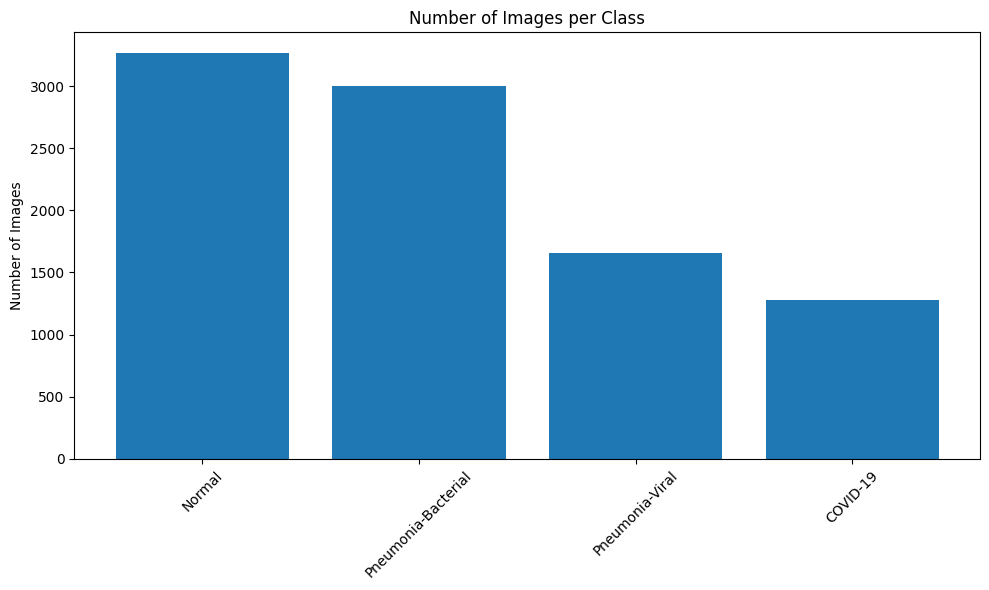


Dataset Statistics:
Normal: 3270 images
Pneumonia-Bacterial: 3001 images
Pneumonia-Viral: 1656 images
COVID-19: 1281 images


In [4]:
# Cell 2: Dataset Statistics and Visualization
def get_dataset_stats():
    """Get statistics about the dataset"""
    stats = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(BASE_PATH, class_name)
        if os.path.exists(class_path):
            n_images = len([f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            stats[class_name] = n_images

    # Plot statistics
    plt.figure(figsize=(10, 6))
    plt.bar(stats.keys(), stats.values())
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

    return stats

stats = get_dataset_stats()
print("\nDataset Statistics:")
for class_name, count in stats.items():
    print(f"{class_name}: {count} images")


Sample Images from Each Class:


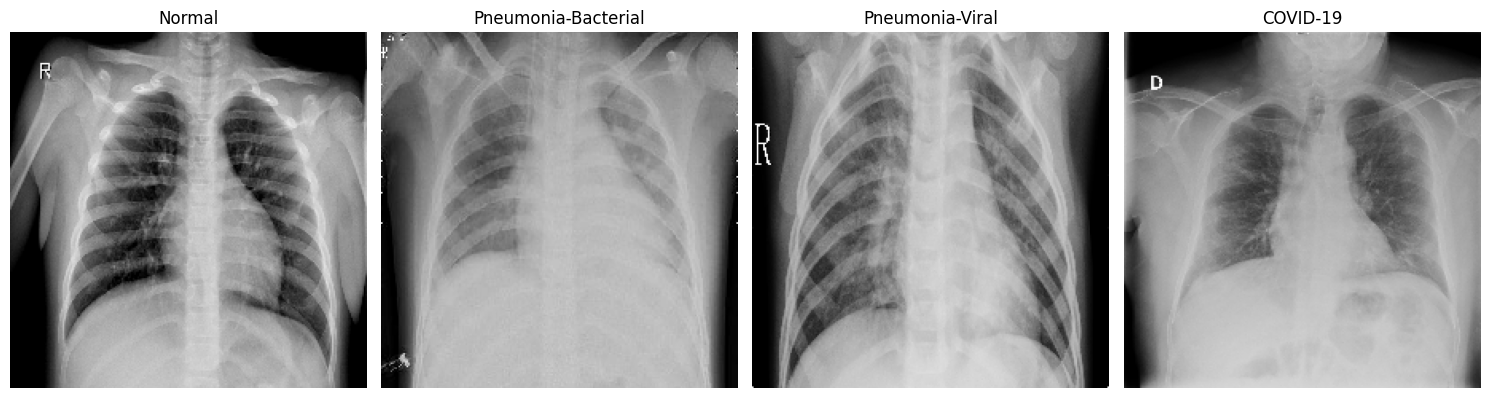

In [5]:
# Cell 3: Display Sample Images
def show_sample_images():
    """Display one sample image from each class"""
    plt.figure(figsize=(15, 4))

    for idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(BASE_PATH, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                img_path = os.path.join(class_path, images[0])
                img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

                plt.subplot(1, 4, idx + 1)
                plt.imshow(img, cmap='gray')
                plt.title(class_name)
                plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nSample Images from Each Class:")
show_sample_images()


In [6]:
# Cell 4: Organize Dataset
def organize_dataset():
    """Organize the dataset into train, validation, and test splits."""
    # Create necessary directories
    splits = ['train', 'val', 'test']
    for split in splits:
        for class_name in CLASS_NAMES:
            os.makedirs(os.path.join(OUTPUT_PATH, split, class_name), exist_ok=True)

    # Create models and logs directories
    os.makedirs(os.path.join(OUTPUT_PATH, 'models'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_PATH, 'logs'), exist_ok=True)

    # Split ratios
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

    split_counts = {'train': {}, 'val': {}, 'test': {}}

    # Process each class
    for class_name in CLASS_NAMES:
        class_path = os.path.join(BASE_PATH, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist!")
            continue

        all_images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        np.random.shuffle(all_images)

        # Calculate split indices
        n_images = len(all_images)
        train_end = int(n_images * TRAIN_RATIO)
        val_end = train_end + int(n_images * VAL_RATIO)

        # Split images
        train_images = all_images[:train_end]
        val_images = all_images[train_end:val_end]
        test_images = all_images[val_end:]

        # Store counts
        split_counts['train'][class_name] = len(train_images)
        split_counts['val'][class_name] = len(val_images)
        split_counts['test'][class_name] = len(test_images)

        # Copy images
        for img, split in zip([train_images, val_images, test_images], ['train', 'val', 'test']):
            for image in img:
                shutil.copy2(
                    os.path.join(class_path, image),
                    os.path.join(OUTPUT_PATH, split, class_name, image)
                )

    return split_counts

print("\nOrganizing Dataset...")
split_counts = organize_dataset()
print("\nDataset Split Statistics:")
for split, counts in split_counts.items():
    print(f"\n{split.upper()} split:")
    for class_name, count in counts.items():
        print(f"{class_name}: {count} images")



Organizing Dataset...

Dataset Split Statistics:

TRAIN split:
Normal: 2289 images
Pneumonia-Bacterial: 2100 images
Pneumonia-Viral: 1159 images
COVID-19: 896 images

VAL split:
Normal: 490 images
Pneumonia-Bacterial: 450 images
Pneumonia-Viral: 248 images
COVID-19: 192 images

TEST split:
Normal: 491 images
Pneumonia-Bacterial: 451 images
Pneumonia-Viral: 249 images
COVID-19: 193 images


# **Augementasi**

Found 6444 images belonging to 4 classes.
Found 1380 images belonging to 4 classes.
Found 1384 images belonging to 4 classes.
Found 2289 images belonging to 1 classes.

Showing original and augmented images for Normal


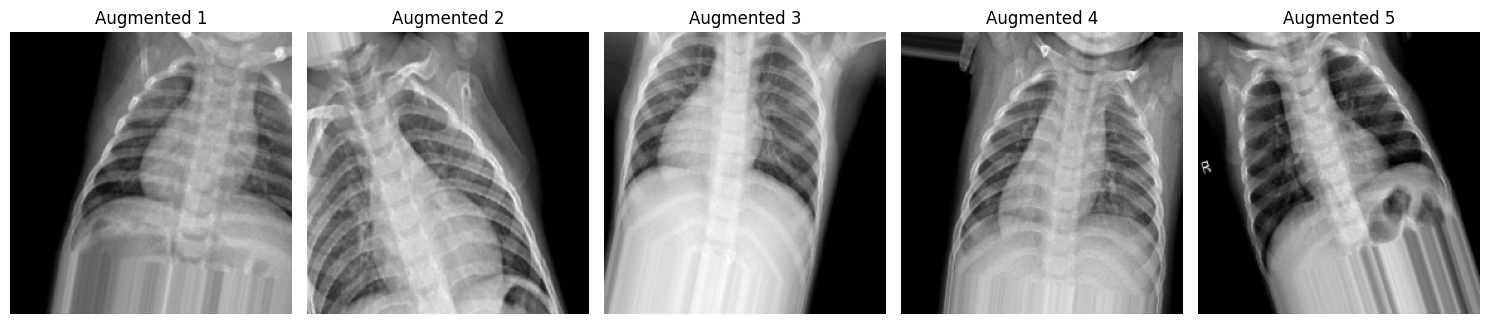

In [7]:
# Cell 5: Create Data Generators and Show Augmentation
def create_data_generators():
    """Create data generators and show sample augmented images"""
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.9, 1.1]
    )

    eval_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow_from_directory(
        os.path.join(OUTPUT_PATH, 'train'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=True
    )

    validation_generator = eval_datagen.flow_from_directory(
        os.path.join(OUTPUT_PATH, 'val'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=False
    )

    test_generator = eval_datagen.flow_from_directory(
        os.path.join(OUTPUT_PATH, 'test'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=False
    )

    # Show augmented images
    def show_augmented_images(generator, title):
        plt.figure(figsize=(15, 5))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            batch = next(generator)
            image = batch[0][0]
            # Reverse preprocessing to show actual image
            image = image - np.min(image)
            image = image / np.max(image)
            plt.imshow(image, cmap='gray')
            plt.title(f'{title} {i+1}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Get a single class generator for demonstration
    single_class_gen = train_datagen.flow_from_directory(
        os.path.join(OUTPUT_PATH, 'train'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        class_mode='categorical',
        classes=[CLASS_NAMES[0]],  # Use first class for demonstration
        shuffle=True
    )

    print("\nShowing original and augmented images for", CLASS_NAMES[0])
    show_augmented_images(single_class_gen, "Augmented")

    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = create_data_generators()


# **ResNet**

In [8]:
# Cell 6: Create Model
def create_model():
    """Create a ResNet50V2 based model for pneumonia classification"""
    # Load ResNet50V2 with pre-trained weights
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create new model on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\nCreating model...")
model = create_model()
model.summary()


Creating model...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,746,244 (94.40 MB)

 Trainable params: 1,181,444 (4.51 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [9]:
# Cell 7: Train Initial Model
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(OUTPUT_PATH, 'models', 'ResNet_model.keras'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("\nStarting initial training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)


Starting initial training...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5989 - loss: 0.9447
Epoch 1: val_accuracy improved from -inf to 0.78478, saving model to /content/processed_dataset/models/ResNet_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 175s 775ms/step - accuracy: 0.5993 - loss: 0.9438 - val_accuracy: 0.7848 - val_loss: 0.5518 - learning_rate: 1.0000e-04
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7605 - loss: 0.5832
Epoch 2: val_accuracy improved from 0.78478 to 0.81159, saving model to /content/processed_dataset/models/ResNet_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 153s 736ms/step - accuracy: 0.7605 - loss: 0.5831 - val_accuracy: 0.8116 - val_loss: 0.4761 - learning_rate: 1.0000e-04
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.7680 - loss: 0.5481
Epoch 3: val_accuracy improved from 0.81159 to 0.82174, saving model to /content/processed_dataset/models/ResNet_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 151s 722ms/step - accuracy: 0.7681 - loss: 0.548

In [10]:
# Cell 8: Fine-tune Model
def fine_tune_model(model, train_generator, validation_generator):
    """Fine-tune the ResNet model after initial training"""
    # Unfreeze the top layers of the base model
    base_model = model.layers[0]
    base_model.trainable = True

    # Freeze all layers except the last few
    for layer in base_model.layers[:-30]:  # Fine-tune last 30 layers
        layer.trainable = False

    # Recompile model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning callbacks
    fine_tune_callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join(OUTPUT_PATH, 'models', 'ResNet_fine_tuned_model.keras'),
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    print("\nStarting fine-tuning...")
    history_fine = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=fine_tune_callbacks
    )

    return model, history_fine

model, history_fine = fine_tune_model(model, train_generator, validation_generator)



Starting fine-tuning...
Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5492 - loss: 1.5892
Epoch 1: val_accuracy improved from -inf to 0.81087, saving model to /content/processed_dataset/models/ResNet_fine_tuned_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 177s 766ms/step - accuracy: 0.5500 - loss: 1.5857 - val_accuracy: 0.8109 - val_loss: 0.4684 - learning_rate: 1.0000e-05
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.8192 - loss: 0.4575
Epoch 2: val_accuracy improved from 0.81087 to 0.82464, saving model to /content/processed_dataset/models/ResNet_fine_tuned_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 147s 705ms/step - accuracy: 0.8192 - loss: 0.4574 - val_accuracy: 0.8246 - val_loss: 0.4491 - learning_rate: 1.0000e-05
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8190 - loss: 0.4380
Epoch 3: val_accuracy improved from 0.82464 to 0.83116, saving model to /content/processed_dataset/models/ResNet_fine_tuned_model.keras
202/202 

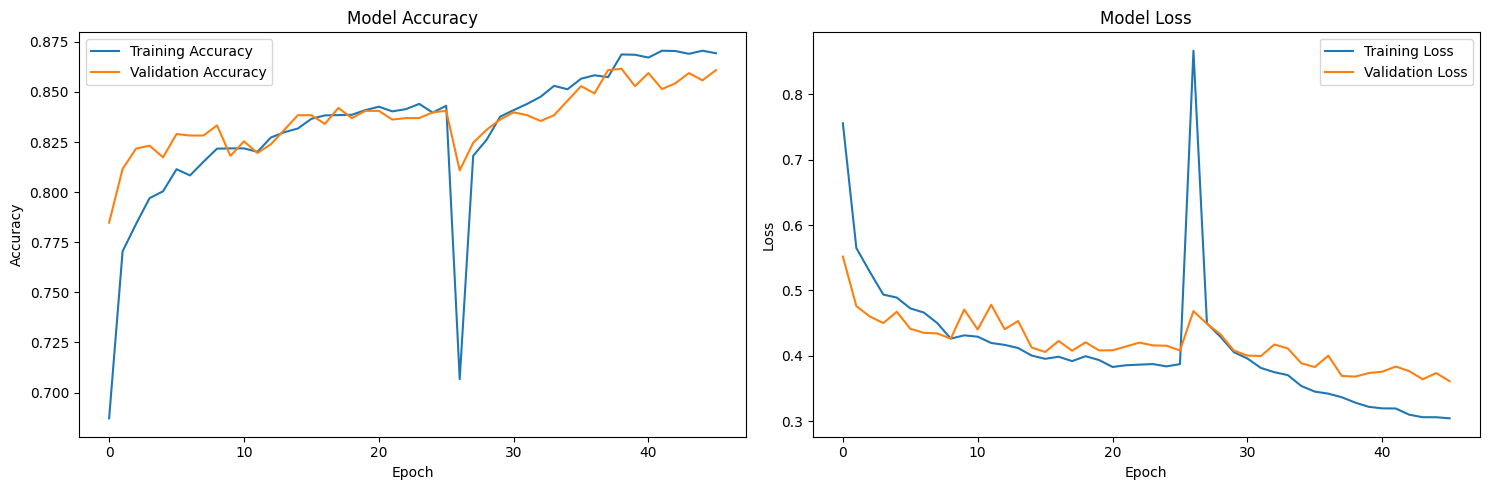

In [11]:
# Cell 9: Plot Training History
def plot_training_history(history, history_fine):
    """Plot the training history including both initial training and fine-tuning"""
    # Combine histories
    combined_history = {
        'accuracy': history.history['accuracy'] + history_fine.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'] + history_fine.history['val_accuracy'],
        'loss': history.history['loss'] + history_fine.history['loss'],
        'val_loss': history.history['val_loss'] + history_fine.history['val_loss']
    }

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(combined_history['accuracy'], label='Training Accuracy')
    plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(combined_history['loss'], label='Training Loss')
    plt.plot(combined_history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'logs', 'training_plots.png'))
    plt.show()

    return combined_history

combined_history = plot_training_history(history, history_fine)

Evaluating validation set...

Evaluating on Validation set...
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step

Validation Classification Report:
                     precision    recall  f1-score   support

             Normal       0.91      0.99      0.95       490
Pneumonia-Bacterial       0.80      0.86      0.83       450
    Pneumonia-Viral       0.73      0.52      0.61       248
           COVID-19       0.99      0.98      0.99       192

           accuracy                           0.86      1380
          macro avg       0.86      0.84      0.84      1380
       weighted avg       0.85      0.86      0.85      1380



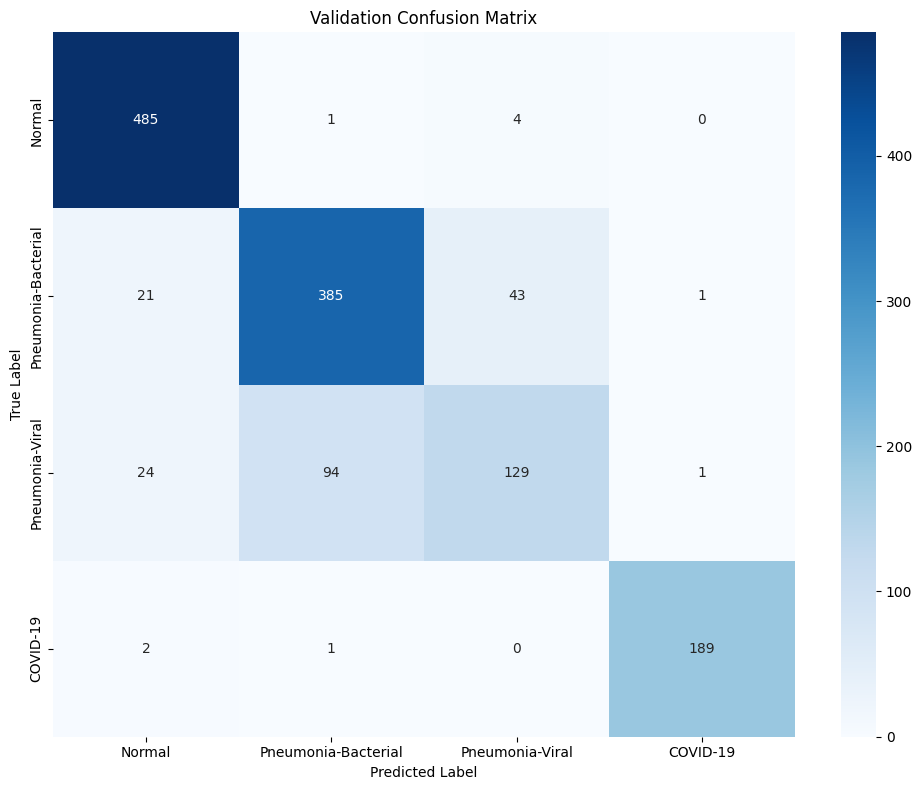

Evaluating test set...

Evaluating on Test set...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 381ms/step

Test Classification Report:
                     precision    recall  f1-score   support

             Normal       0.90      0.99      0.94       491
Pneumonia-Bacterial       0.77      0.82      0.80       451
    Pneumonia-Viral       0.65      0.46      0.54       249
           COVID-19       0.98      0.96      0.97       193

           accuracy                           0.84      1384
          macro avg       0.83      0.81      0.81      1384
       weighted avg       0.82      0.84      0.83      1384



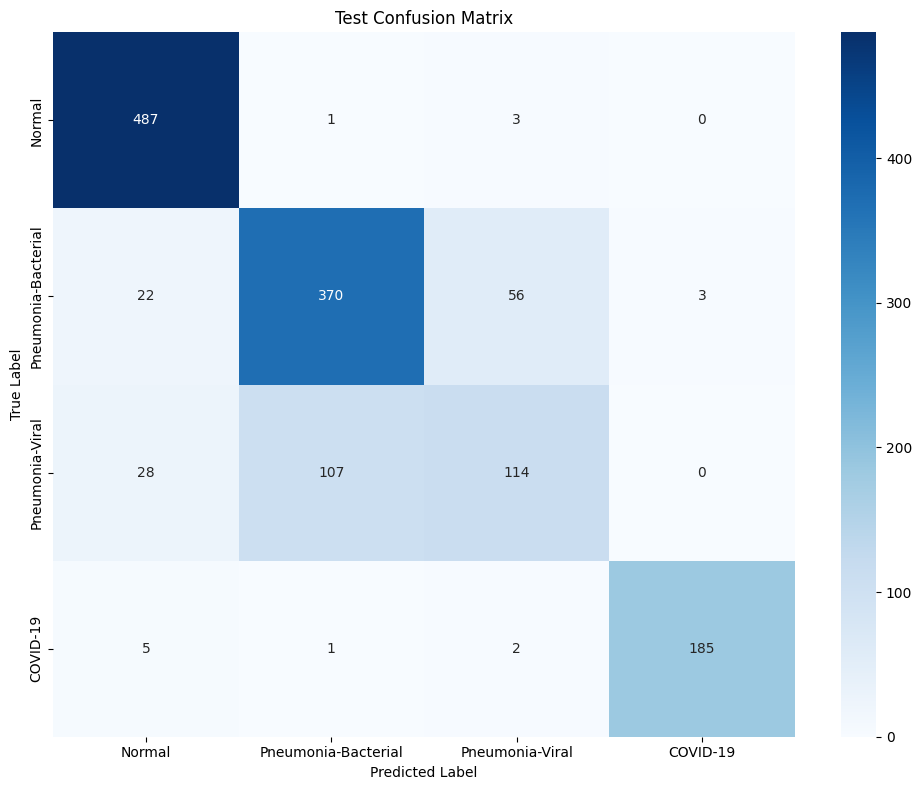

In [14]:
# Cell 10: Model Evaluation
def evaluate_model(model, generator, split_name):
    """Evaluate the model and generate classification report and confusion matrix"""
    print(f"\nEvaluating on {split_name} set...")

    # Get predictions
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print(f"\n{split_name} Classification Report:")
    print(report)

    # Save report to file
    with open(os.path.join(OUTPUT_PATH, 'logs', f'{split_name.lower()}_classification_report.txt'), 'w') as f:
        f.write(report)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title(f'{split_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Evaluasi pada validation set
print("Evaluating validation set...")
evaluate_model(model, validation_generator, "Validation")

# Evaluasi pada test set
print("Evaluating test set...")
evaluate_model(model, test_generator, "Test")

# **VGG**

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import pandas as pd
import shutil

In [16]:
# Cell 11: Create VGG16 Model
def create_vgg_model():
    """Create a VGG16 based model for pneumonia classification"""
    # Load VGG16 with pre-trained weights
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create new model on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("\nCreating VGG16 model...")
model = create_vgg_model()
model.summary()


Creating VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,766,852 (60.15 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Cell 12: Train Initial Model
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(OUTPUT_PATH, 'models', 'VGG16_model.keras'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("\nStarting initial training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)


Starting initial training...
Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.4173 - loss: 1.2680
Epoch 1: val_accuracy improved from -inf to 0.60217, saving model to /content/processed_dataset/models/VGG16_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 178s 775ms/step - accuracy: 0.4178 - loss: 1.2673 - val_accuracy: 0.6022 - val_loss: 0.9523 - learning_rate: 1.0000e-04
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.6779 - loss: 0.8229
Epoch 2: val_accuracy improved from 0.60217 to 0.73841, saving model to /content/processed_dataset/models/VGG16_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 150s 717ms/step - accuracy: 0.6779 - loss: 0.8227 - val_accuracy: 0.7384 - val_loss: 0.6992 - learning_rate: 1.0000e-04
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.7237 - loss: 0.6846
Epoch 3: val_accuracy improved from 0.73841 to 0.74130, saving model to /content/processed_dataset/models/VGG16_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 205s 736ms

In [18]:
# Cell 13: Fine-tune Model
def fine_tune_model(model, train_generator, validation_generator):
    """Fine-tune the VGG16 model after initial training"""
    # Unfreeze the top layers of the base model
    base_model = model.layers[0]
    base_model.trainable = True

    # Freeze all layers except the last few blocks
    for layer in base_model.layers[:-4]:  # Fine-tune last 4 blocks
        layer.trainable = False

    # Recompile model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning callbacks
    fine_tune_callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join(OUTPUT_PATH, 'models', 'VGG16_fine_tuned_model.keras'),
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    print("\nStarting fine-tuning...")
    history_fine = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=fine_tune_callbacks
    )

    return model, history_fine

model, history_fine = fine_tune_model(model, train_generator, validation_generator)


Starting fine-tuning...
Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.7848 - loss: 0.5219
Epoch 1: val_accuracy improved from -inf to 0.80797, saving model to /content/processed_dataset/models/VGG16_fine_tuned_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 154s 712ms/step - accuracy: 0.7848 - loss: 0.5218 - val_accuracy: 0.8080 - val_loss: 0.5155 - learning_rate: 1.0000e-05
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8231 - loss: 0.4462
Epoch 2: val_accuracy improved from 0.80797 to 0.82319, saving model to /content/processed_dataset/models/VGG16_fine_tuned_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 146s 699ms/step - accuracy: 0.8230 - loss: 0.4462 - val_accuracy: 0.8232 - val_loss: 0.4450 - learning_rate: 1.0000e-05
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8315 - loss: 0.4123
Epoch 3: val_accuracy improved from 0.82319 to 0.82899, saving model to /content/processed_dataset/models/VGG16_fine_tuned_model.keras
202/202 ━━━

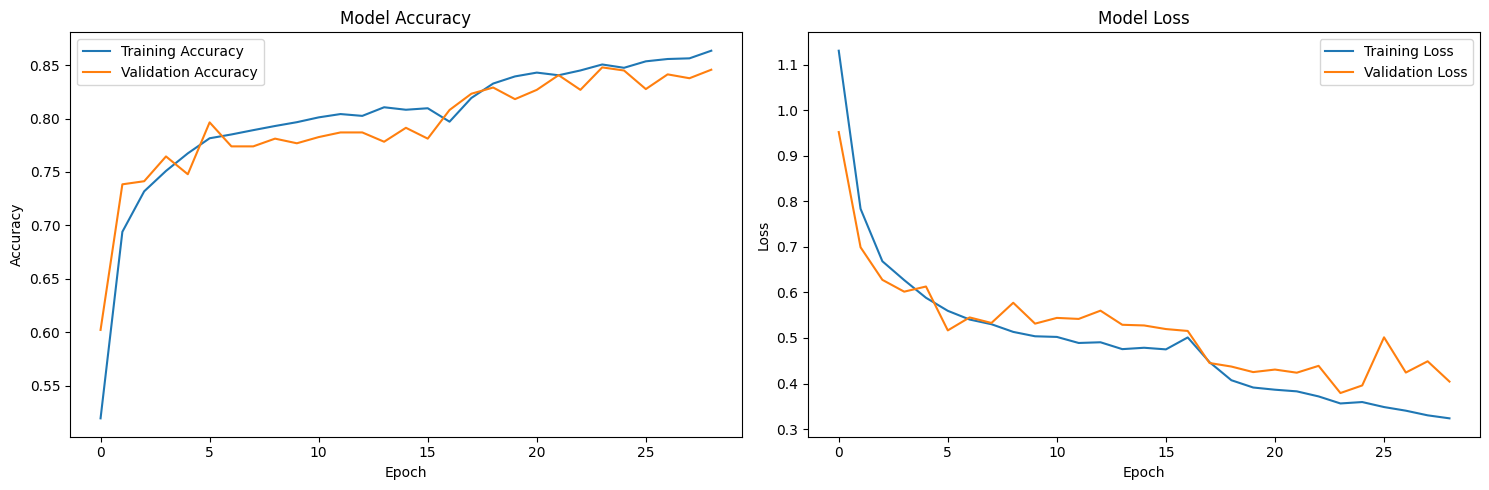

In [19]:
# Cell 14: Plot Training History
def plot_training_history(history, history_fine):
    """Plot the training history including both initial training and fine-tuning"""
    # Combine histories
    combined_history = {
        'accuracy': history.history['accuracy'] + history_fine.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'] + history_fine.history['val_accuracy'],
        'loss': history.history['loss'] + history_fine.history['loss'],
        'val_loss': history.history['val_loss'] + history_fine.history['val_loss']
    }

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(combined_history['accuracy'], label='Training Accuracy')
    plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(combined_history['loss'], label='Training Loss')
    plt.plot(combined_history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'logs', 'vgg16_training_plots.png'))
    plt.show()

    return combined_history

combined_history = plot_training_history(history, history_fine)


Evaluating on Test set...
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 386ms/step

Test Classification Report:
                     precision    recall  f1-score   support

             Normal       0.89      0.99      0.94       491
Pneumonia-Bacterial       0.76      0.82      0.79       451
    Pneumonia-Viral       0.65      0.42      0.51       249
           COVID-19       0.98      0.96      0.97       193

           accuracy                           0.83      1384
          macro avg       0.82      0.80      0.80      1384
       weighted avg       0.82      0.83      0.82      1384



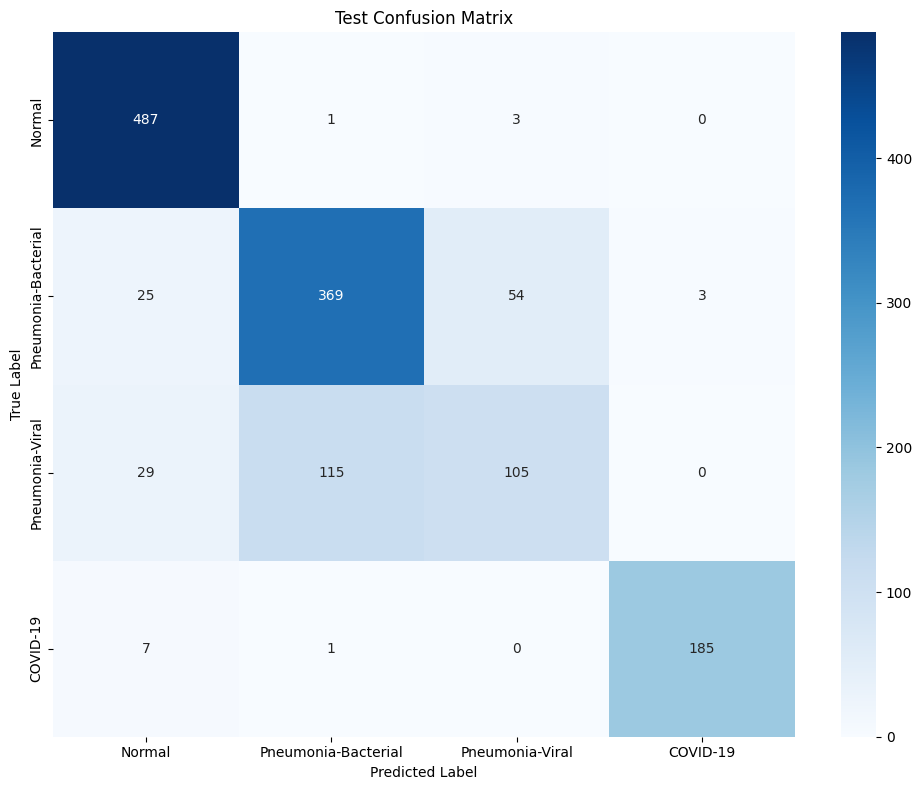

In [20]:
# Cell 10: Model Evaluation
def evaluate_model(model, generator, split_name):
    """Evaluate the model and generate classification report and confusion matrix"""
    print(f"\nEvaluating on {split_name} set...")

    # Get predictions
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print(f"\n{split_name} Classification Report:")
    print(report)

    # Save report to file
    with open(os.path.join(OUTPUT_PATH, 'logs', f'vgg16_{split_name.lower()}_classification_report.txt'), 'w') as f:
        f.write(report)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title(f'{split_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'logs', f'vgg16_{split_name.lower()}_confusion_matrix.png'))
    plt.show()

    return report, cm

# Evaluate the model on test set
test_report, test_cm = evaluate_model(model, test_generator, "Test")